In [1]:
import polars as pl
import numpy as np
from datetime import datetime

tran_pd = pl.read_parquet("data/df_transaction.pa")
tr_pd = pl.read_parquet("data/train.pa")


In [2]:
train_ids = set(tr_pd["client_num"].unique())
all_ids = set(tran_pd["client_num"].unique())
test_ids = all_ids - train_ids

tran_pd = tran_pd.with_columns([
    pl.col("client_num").is_in(list(train_ids)).alias("is_train")
])

tst_pd = pl.DataFrame({"client_num": list(test_ids)})


In [3]:
tran_pd = tran_pd.with_columns([
    pl.col("date_time").dt.weekday().alias("weekday"),
    pl.col("date_time").dt.hour().alias("hour"),
    pl.col("date_time").dt.day().alias("month_day"),
    pl.col("date_time").dt.month().alias("month"),
    pl.col("date_time").dt.week().alias("week")
])

tran_pd = tran_pd.with_columns([
    pl.col("weekday").is_in([5, 6]).alias("is_weekend"),
    pl.when(pl.col("hour").is_between(5, 12)).then(pl.lit("morning"))
      .when(pl.col("hour").is_between(12, 17)).then(pl.lit("day"))
      .when(pl.col("hour").is_between(17, 22)).then(pl.lit("evening"))
      .otherwise(pl.lit("night"))
      .alias("time_of_day")
])



In [4]:
tran_pd = tran_pd.with_columns([
    pl.when(pl.col("month_day") <= 10).then(pl.lit("early"))
      .when(pl.col("month_day") <= 20).then(pl.lit("middle"))
      .otherwise(pl.lit("late"))
      .alias("part_of_month"),
    
    (pl.col("month") == 7).alias("is_july"),
    (pl.col("month") == 8).alias("is_august"),
    (pl.col("month") == 9).alias("is_september"),
    (pl.col("month") == 10).alias("is_october")
])


In [5]:
from datetime import datetime

holidays = [datetime(2024, 7, 1).date(),
            datetime(2024, 7, 2).date(),
            datetime(2024, 8, 22).date(),
            datetime(2024, 9, 1).date(),
            datetime(2024, 10, 4).date()]

tran_pd = tran_pd.with_columns([
    pl.col("date_time").dt.date().is_in(holidays).alias("is_holiday")
])


In [6]:
tran_pd = tran_pd.with_columns([
    pl.col("mcc_code").cast(str).str.zfill(4)
])

for i in range(4):
    tran_pd = tran_pd.with_columns([
        pl.col("mcc_code").str.slice(i, 1).cast(pl.Int64).alias(f"mcc_digit_{i}")
    ])

tran_pd = tran_pd.with_columns([
    pl.col("mcc_code").str.slice(0, 2).alias("mcc_pair_01"),
    
    pl.concat_str([
        pl.col("mcc_code").str.slice(1, 1),
        pl.col("mcc_code").str.slice(2, 1)
    ]).alias("mcc_pair_12"),

    pl.col("mcc_code").str.slice(2, 2).alias("mcc_pair_23"),
    pl.col("mcc_code").str.slice(0, 3).alias("mcc_triplet_012"),
    pl.col("mcc_code").str.slice(1, 3).alias("mcc_triplet_123")
])


In [7]:
merchant_freq = tran_pd.group_by("merchant_name").agg(pl.count()).rename({"count": "merchant_freq"})
tran_pd = tran_pd.join(merchant_freq, on="merchant_name", how="left")

tran_pd = tran_pd.with_columns([
    (pl.col("merchant_freq") > 500).alias("is_popular_merchant")
])

C:\Users\Admin\AppData\Local\Temp\ipykernel_56432\1365750222.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  merchant_freq = tran_pd.group_by("merchant_name").agg(pl.count()).rename({"count": "merchant_freq"})


In [8]:
import numpy as np

# Фильтрация null
tran_pd = tran_pd.filter(pl.col("amount").is_not_null())

# Вычисление бинов
min_amount = tran_pd.select(pl.col("amount").min()).item()
max_amount = tran_pd.select(pl.col("amount").max()).item()
bins = np.linspace(min_amount, max_amount, 11)

# digitize возвращает индекс интервала, в который попадает значение
bin_indices = np.digitize(tran_pd["amount"].to_numpy(), bins) - 1  # -1 чтобы индексы были от 0 до 9

# Ограничиваем значения на случай переполнения последнего интервала
bin_indices = np.clip(bin_indices, 0, 9)

# Добавляем колонку обратно
tran_pd = tran_pd.with_columns([
    pl.Series("amount_bin", bin_indices)
])

# One-hot
tran_pd = tran_pd.to_dummies(columns=["amount_bin"])


In [9]:
tran_pd = tran_pd.sort(by=["client_num", "date_time"])

tran_pd = tran_pd.with_columns([
    pl.col("amount").rolling_mean(window_size=7).over("client_num").alias("rolling_mean_7"),
    pl.col("amount").rolling_std(window_size=7).over("client_num").fill_null(0).alias("rolling_std_7"),
    pl.col("amount").rolling_mean(window_size=30).over("client_num").alias("rolling_mean_30"),
    pl.col("amount").rolling_std(window_size=30).over("client_num").fill_null(0).alias("rolling_std_30")
])

In [10]:
weekly_counts = tran_pd.group_by(["client_num", "week"]).count().select(["client_num", "week", "count"])
weekly_stats = weekly_counts.group_by("client_num").agg([
    pl.col("count").mean().alias("mean_weekly_txn"),
    pl.col("count").std().alias("std_weekly_txn"),
    pl.col("count").max().alias("max_weekly_txn")
])


C:\Users\Admin\AppData\Local\Temp\ipykernel_56432\3897066321.py:1: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  weekly_counts = tran_pd.group_by(["client_num", "week"]).count().select(["client_num", "week", "count"])


In [11]:
# Найдём последнюю дату в таблице
max_date = tran_pd.select(pl.col("date_time").max()).item()

# Считаем последнюю активность и разницу в днях
last_activity = (
    tran_pd.group_by("client_num")
    .agg(pl.col("date_time").max().alias("last_txn_date"))
    .with_columns(
        (pl.lit(max_date) - pl.col("last_txn_date")).alias("duration")
    )
    .with_columns(
        (pl.col("duration").cast(pl.Int64) / (86_400_000_000_000)).alias("days_since_last_txn")
    )
    .drop("duration")
)


In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression

monthly = tran_pd.with_columns([
    pl.col("date_time").dt.strftime("%Y-%m").alias("year_month")
]).group_by(["client_num", "year_month"]).agg(
    pl.col("amount").mean().alias("monthly_amount")
)

# Переводим в pandas
monthly_pd = monthly.to_pandas()

# Добавляем month_num по клиенту
monthly_pd["month_num"] = monthly_pd.groupby("client_num").cumcount()

def compute_trend(group):
    if group.shape[0] < 2:
        return pd.Series({"amount_trend": 0})
    model = LinearRegression()
    model.fit(group["month_num"].values.reshape(-1, 1), group["monthly_amount"].values)
    return pd.Series({"amount_trend": model.coef_[0]})

# Группируем и применяем регрессию
trend_df = monthly_pd.groupby("client_num").apply(compute_trend).reset_index()


C:\Users\Admin\AppData\Local\Temp\ipykernel_56432\4044124985.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_df = monthly_pd.groupby("client_num").apply(compute_trend).reset_index()


In [13]:
# merchant agg
agg_merchant = tran_pd.group_by("client_num").agg([
    pl.col("merchant_name").n_unique().alias("unique_merchants"),
    pl.col("merchant_freq").mean().alias("mean_merchant_freq"),
    pl.col("merchant_freq").max().alias("max_merchant_freq"),
    pl.col("is_popular_merchant").mean().alias("popular_merchant_rate")
])

# time agg
agg_time = tran_pd.group_by("client_num").agg([
    pl.col("is_weekend").mean().alias("weekend_rate"),
    pl.col("is_holiday").mean().alias("holiday_rate")
])

# time-of-day (one-hot)
tran_pd = tran_pd.to_dummies(columns=["time_of_day"])
agg_tod = tran_pd.group_by("client_num").mean().select(["client_num"] + [col for col in tran_pd.columns if col.startswith("time_of_day_")])

# mcc
agg_mcc = tran_pd.group_by("client_num").agg([
    pl.col("mcc_pair_01").n_unique().alias("unique_mcc_pairs"),
    pl.col("mcc_triplet_012").n_unique().alias("unique_mcc_triplets")
])

# amount binned
amount_bin_cols = [col for col in tran_pd.columns if col.startswith("amount_bin_")]
agg_bins = tran_pd.group_by("client_num").mean().select(["client_num"] + amount_bin_cols)


In [14]:
trend_pl = pl.from_pandas(trend_df)


client_features = tran_pd.group_by("client_num").agg([
    pl.count("amount").alias("count_amount"),
    pl.mean("amount").alias("avg_amount"),
    pl.sum("amount").alias("total_amount"),
    pl.std("amount").alias("std_amount"),
    pl.min("amount").alias("min_amount"),
    pl.max("amount").alias("max_amount"),
    pl.col("mcc_code").n_unique().alias("unique_mccs"),
    pl.min("date_time").alias("first_txn"),
    pl.max("date_time").alias("last_txn")
])

client_features_ext = client_features \
    .join(agg_merchant, on="client_num") \
    .join(agg_time, on="client_num") \
    .join(agg_tod, on="client_num") \
    .join(agg_mcc, on="client_num") \
    .join(agg_bins, on="client_num")

client_features_final = client_features_ext \
    .join(weekly_stats, on="client_num") \
    .join(last_activity, on="client_num") \
     .join(trend_pl, on="client_num") \

tr_features = tr_pd.join(client_features_final, on="client_num", how="left")
tst_features = tst_pd.join(client_features_final, on="client_num", how="left")


In [15]:
tr_features_pd = tr_features.to_pandas()
tst_features_pd = tst_features.to_pandas()

In [16]:
# список pandas-DF
dfs = [tr_features_pd, tst_features_pd]

for df in dfs:
    # находим колонки с типом datetime
    datetime_cols = df.select_dtypes(include=["datetime64[ns]"]).columns
    for col in datetime_cols:
        # 1) конвертация в int64 наносекунд → секунды
        df[col] = (df[col].astype("int64") // 10**9).astype("int64")
        # 2) нормировка: вычитаем из всех значений min
        df[col] = df[col] - df[col].min()


In [19]:
tr_features_pd.columns

Index(['client_num', 'target', 'count_amount', 'avg_amount', 'total_amount',
       'std_amount', 'min_amount', 'max_amount', 'unique_mccs', 'first_txn',
       'last_txn', 'unique_merchants', 'mean_merchant_freq',
       'max_merchant_freq', 'popular_merchant_rate', 'weekend_rate',
       'holiday_rate', 'time_of_day_day', 'time_of_day_evening',
       'time_of_day_morning', 'time_of_day_night', 'unique_mcc_pairs',
       'unique_mcc_triplets', 'amount_bin_0', 'amount_bin_1', 'amount_bin_2',
       'amount_bin_3', 'amount_bin_4', 'amount_bin_5', 'amount_bin_6',
       'amount_bin_8', 'amount_bin_9', 'mean_weekly_txn', 'std_weekly_txn',
       'max_weekly_txn', 'last_txn_date', 'days_since_last_txn',
       'amount_trend'],
      dtype='object')

In [18]:
ы

NameError: name 'ы' is not defined

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd


lgb_X = tr_features_pd.drop(columns=["target", "client_num"])
lgb_y = tr_features_pd["target"]
lgb_X_test = tst_features_pd.drop(columns=["client_num"])

lgb_categorical_features = tr_features_pd.select_dtypes(include=['category', 'object']).columns.tolist()

lgb_X_train, lgb_X_val, lgb_y_train, lgb_y_val = train_test_split(
    lgb_X, lgb_y, test_size=0.2, random_state=42, stratify=lgb_y
)

lgb_train_data = lgb.Dataset(lgb_X_train, label=lgb_y_train, categorical_feature=lgb_categorical_features, free_raw_data=False)
lgb_val_data = lgb.Dataset(lgb_X_val, label=lgb_y_val, categorical_feature=lgb_categorical_features, reference=train_data, free_raw_data=False)

lgb_params = {
    "objective": "multiclass",
    "num_class": 8,
    "metric": "None",  # отключаем встроенные метрики
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": 7,
    "verbosity": -1,
    "seed": 42,
}

weights_by_class = {
    0: 1.00,
    1: 0.72,
    2: 0.52,
    3: 0.37,
    4: 0.27,
    5: 0.19,
    6: 0.14,
    7: 0.00,
}

def compute_wmae(y_true, y_pred):
    """WMAE: y_pred и y_true — 1D numpy-массивы классов"""
    weights = np.vectorize(weights_by_class.get)(y_true)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

def feval_wmae(preds, train_data):
    """LightGBM-compatible WMAE function"""
    y_true = train_data.get_label()
    y_pred = preds.reshape(-1, 8).argmax(axis=1)
    weights = np.vectorize(weights_by_class.get)(y_true)
    error = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
    return "wmae", error, False  # False → метрика "чем меньше, тем лучше"


model = lgb.train(
    lgb_params,
    lgb_train_data,
    valid_sets=[lgb_val_data],
    feval=feval_wmae,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
    ],
)


lgb_val_preds_proba = model.predict(lgb_X_val)
lgb_val_preds_class = lgb_val_preds_proba.argmax(axis=1)
lgb_y_val_np = lgb_y_val.to_numpy()

wmae_score = compute_wmae(lgb_y_val_np, lgb_val_preds_class)
print(f"\n📊 Validation WMAE: {wmae_score:.5f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's wmae: 0.952824

📊 Validation WMAE: 0.95282


In [ ]:
test_preds = model.predict(lgb_X_test)
test_preds_labels = test_preds.argmax(axis=1)

submission = pd.DataFrame({
    "client_num": tst_features_pd["client_num"],
    "target": test_preds_labels
})

submission.to_csv("submission.csv", index=False)

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Подготовка данных
cat_X = tr_features_pd.drop(columns=["target", "client_num"])
cat_y = tr_features_pd["target"]
cat_X_test = tst_features_pd.drop(columns=["client_num"])

# Определение категориальных признаков
cat_cat_features = tr_features_pd.select_dtypes(include=['category', 'object']).columns.tolist()

# Разделение на train/val
cat_X_train, cat_X_val, cat_y_train, cat_y_val = train_test_split(
    cat_X, cat_y, test_size=0.2, random_state=42, stratify=cat_y
)

# Веса классов (аналогично вашему LightGBM примеру)
class_weights = {
    0: 1.00,
    1: 0.72,
    2: 0.52,
    3: 0.37,
    4: 0.27,
    5: 0.19,
    6: 0.14,
    7: 0.00,
}

# Создание весов для каждого образца
sample_weights = cat_y_train.map(class_weights)

# Создание Pool объектов (аналог Dataset в LightGBM)
cat_train_pool = Pool(cat_X_train, cat_y_train, cat_features=cat_cat_features, weight=sample_weights)
cat_val_pool = Pool(cat_X_val, cat_y_val, cat_features=cat_cat_features)

# Параметры модели CatBoost
cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 7,
    'loss_function': 'MultiClass',
    'classes_count': 8,
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'eval_metric': 'TotalF1',  # Можно изменить на другой подходящий metric
    'use_best_model': True
}

# Инициализация и обучение модели
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(
    cat_train_pool,
    eval_set=cat_val_pool,
    plot=True
)

# Предсказание вероятностей для валидационного набора
cat_val_preds_proba = cat_model.predict_proba(cat_X_val)  # Получаем вероятности классов

# Предсказание вероятностей для тестового набора
cat_test_preds_proba = cat_model.predict_proba(cat_X_test)

# Создание DataFrame с вероятностями
cat_val_prob_df = pd.DataFrame(cat_val_preds_proba, 
                          columns=[f"class_{i}_prob" for i in range(8)],
                          index=cat_X_val.index)
cat_val_prob_df['true_class'] = cat_y_val

cat_test_prob_df = pd.DataFrame(cat_test_preds_proba,
                          columns=[f"class_{i}_prob" for i in range(8)],
                          index=cat_X_test.index)

# Вывод информации о вероятностях
print("Валидационные вероятности:")
print(cat_val_prob_df.head())

# Если нужно вычислить WMAE (аналогично вашему LightGBM примеру)
def compute_wmae(y_true, y_pred):
    weights = np.vectorize(class_weights.get)(y_true)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

val_preds_class = cat_val_preds_proba.argmax(axis=1)
wmae_score = compute_wmae(cat_y_val.values, val_preds_class)
print(f"\n📊 Validation WMAE: {wmae_score:.5f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Found only 7 unique classes in the data, but have defined 8 classes. Probably something is wrong with data.


0:	learn: 0.3442301	test: 0.1718262	best: 0.1718262 (0)	total: 44.2ms	remaining: 44.2s
100:	learn: 0.3874795	test: 0.2132286	best: 0.2132286 (100)	total: 4.65s	remaining: 41.4s
200:	learn: 0.4107730	test: 0.2239916	best: 0.2244199 (187)	total: 9.2s	remaining: 36.6s
300:	learn: 0.4302942	test: 0.2303476	best: 0.2303476 (300)	total: 13.7s	remaining: 31.8s
400:	learn: 0.4485136	test: 0.2349638	best: 0.2349977 (397)	total: 18.2s	remaining: 27.2s
500:	learn: 0.4661071	test: 0.2379759	best: 0.2396036 (487)	total: 22.8s	remaining: 22.7s
600:	learn: 0.4826988	test: 0.2409539	best: 0.2410636 (599)	total: 27.3s	remaining: 18.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2423330965
bestIteration = 631

Shrink model to first 632 iterations.
Валидационные вероятности:
       class_0_prob  class_1_prob  class_2_prob  class_3_prob  class_4_prob  \
68034      0.662188      0.243514      0.050917      0.016535      0.013539   
60831      0.368353      0.407257      0.133323    

In [ ]:
est_preds_proba = cat_model.predict_proba(cat_X_test)

# Получаем предсказанные классы (метки)
cat_val_preds_class = cat_test_preds_proba.argmax(axis=1)

# Создание submission файла в том же формате, что и в LightGBM
submission = pd.DataFrame({
    "client_num": tst_features_pd["client_num"],
    "target": cat_val_preds_class
})

# Сохранение в файл
submission.to_csv("cat_submission.csv", index=False)

In [ ]:
res = pd.DataFrame()

#res['lgb_prob'] = lgb_val_preds_proba
res['lgb_class'] = test_preds_labels
#res['cat_prob'] = cat_val_preds_proba
res['cat_class'] = cat_val_preds_class

res

,lgb_class,cat_class
0,1,1
1,1,0
2,1,0
3,4,4
4,1,1
...,...,...
39138,1,0
39139,0,0
39140,1,1
39141,1,0


In [ ]:
len(lgb_val_preds_class)

14000

In [ ]:
ы

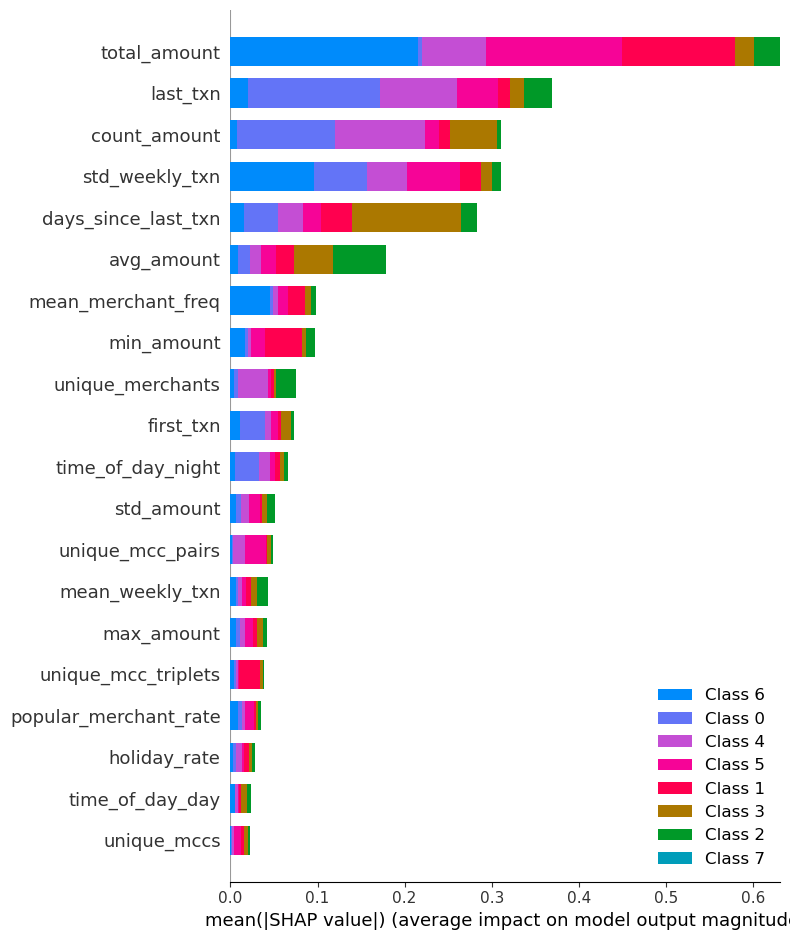

In [ ]:
import shap

# Инициализируем explainer с вашей моделью
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP значения для валидационного набора (можно использовать и тренировочный)
shap_values = explainer.shap_values(X_val)

# Визуализация важности признаков (среднее абсолютное значение SHAP)
shap.summary_plot(shap_values, X_val, plot_type="bar")